In [23]:
#Training and validation directories
train_dir = 'training images directory'
test_dir = 'validation images directory'

In [24]:
#importation of libraries
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [25]:
#define some parameters
num_classes = 2
img_width = 224
img_height = 224
batch_size = 64
epochs = 15

In [33]:
# Setup the model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, None, None, 3 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, None, None, 3 0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

In [34]:
#Apply data augmentation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
		batch_size=32,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


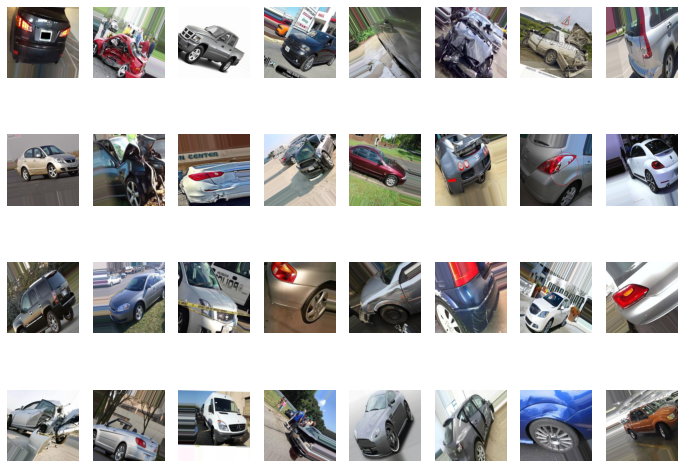

In [31]:
#Plot training images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [40]:
#Train the model
history = model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=None,
    validation_data=validation_generator,
    validation_steps=None)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 43s 602ms/step - loss: 0.4966 - accuracy: 0.7924 - val_loss: 106.9385 - val_accuracy: 0.5000
Epoch 2/20
58/58 [==============================] - 32s 555ms/step - loss: 0.3546 - accuracy: 0.8554 - val_loss: 38.7610 - val_accuracy: 0.5000
Epoch 3/20
58/58 [==============================] - 32s 558ms/step - loss: 0.3211 - accuracy: 0.8685 - val_loss: 3.8033 - val_accuracy: 0.6239
Epoch 4/20
58/58 [==============================] - 32s 554ms/step - loss: 0.3047 - accuracy: 0.8832 - val_loss: 0.5001 - val_accuracy: 0.8370
Epoch 5/20
58/58 [==============================] - 32s 553ms/step - loss: 0.2875 - accuracy: 0.8810 - val_loss: 0.7243 - val_accuracy: 0.7739
Epoch 6/20
58/58 [==============================] - 32s 555ms/step - loss: 0.2476 - accuracy: 0.8978 - val_loss: 0.8342 - val_accuracy: 0.7522
Epoch 7/20
58/58 [==============================] - 32s 555ms/step - loss: 0.2502 - accuracy: 0.9022 - val_loss: 0.9195 - val_accuracy: 0.7

In [41]:

save_dir = 'directory to where the model will be saved'
model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/car_damaged_detection/car_damaged_detection.model/assets


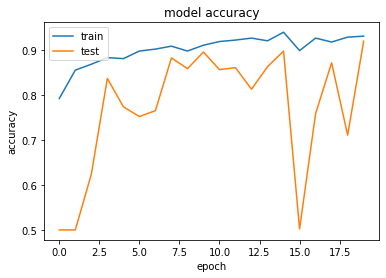

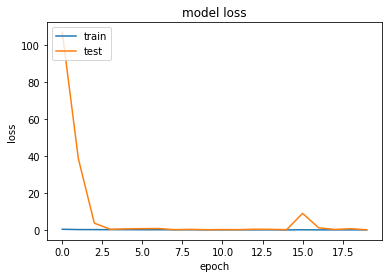

In [42]:
# Plot accuracy history 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot loss history 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

array([1.0000000e+00, 1.1585563e-08], dtype=float32)

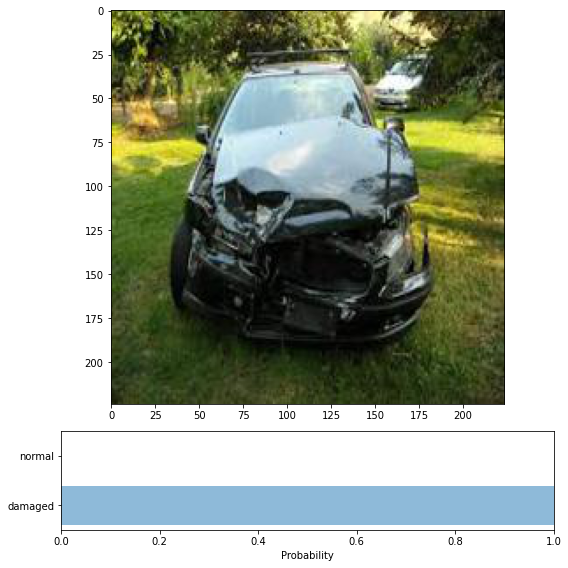

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("damaged", "normal")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

model = load_model(save_dir)

img = image.load_img('image to test path', target_size=(img_height, img_width))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds